In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
pip install --upgrade pip

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 50.3 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 24.1.2
    Uninstalling pip-24.1.2:
      Successfully uninstalled pip-24.1.2


In [6]:
import os
working_dir = '/content/drive/My Drive/nlp_final_project'
os.chdir(working_dir)

In [4]:
pip install -r requirements.txt

  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [6]:
import os
os.environ["WANDB_MODE"] = "disabled"

In [15]:
#Create XNLI datasets
from datasets import load_dataset, concatenate_datasets

xnli_en = load_dataset("facebook/xnli", "en")
xnli_ru = load_dataset("facebook/xnli", "ru")

xnli_en = xnli_en.map(lambda examples: {'language': 'en'})
xnli_ru = xnli_ru.map(lambda examples: {'language': 'ru'})

train_dataset = concatenate_datasets([xnli_en['train'], xnli_ru['train']])
validation_dataset = concatenate_datasets([xnli_en['validation'], xnli_ru['validation']])
test_dataset = concatenate_datasets([xnli_en['test'], xnli_ru['test']])

train_dataset.save_to_disk("xnli_train_en_ru")
validation_dataset.save_to_disk("xnli_validation_en_ru")
test_dataset.save_to_disk("xnli_test_en_ru")

README.md:   0%|          | 0.00/20.8k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/50.2M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/308k [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/157k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/392702 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/5010 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2490 [00:00<?, ? examples/s]

train-00000-of-00001.parquet:   0%|          | 0.00/70.0M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/477k [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/239k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/392702 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/5010 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2490 [00:00<?, ? examples/s]

Map:   0%|          | 0/392702 [00:00<?, ? examples/s]

Map:   0%|          | 0/5010 [00:00<?, ? examples/s]

Map:   0%|          | 0/2490 [00:00<?, ? examples/s]

Map:   0%|          | 0/392702 [00:00<?, ? examples/s]

Map:   0%|          | 0/5010 [00:00<?, ? examples/s]

Map:   0%|          | 0/2490 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/785404 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/4980 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/10020 [00:00<?, ? examples/s]

Label 1 (Neutral): 261800 examples
Label 0 (Entailment): 261798 examples
Label 2 (Contradiction): 261806 examples


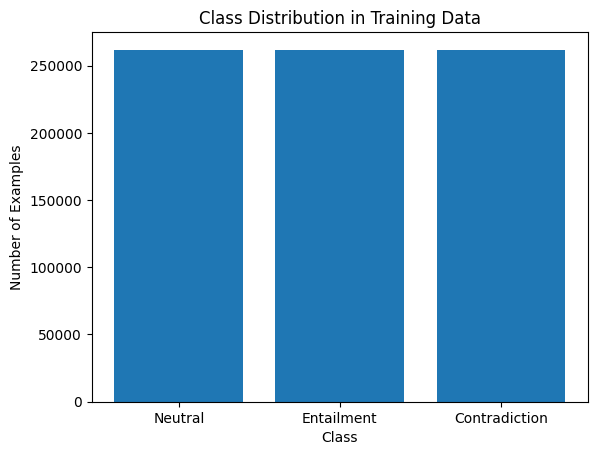

In [10]:
from datasets import load_from_disk
import matplotlib.pyplot as plt

train_dataset = load_from_disk("xnli_train_en_ru")
labels = train_dataset['label']

from collections import Counter
label_counts = Counter(labels)

label_map = {
    0: 'Entailment',
    1: 'Neutral',
    2: 'Contradiction'
}

for label_id, count in label_counts.items():
    print(f"Label {label_id} ({label_map[label_id]}): {count} examples")

plt.bar(
    [label_map[label_id] for label_id in label_counts.keys()],
    label_counts.values()
)
plt.title("Class Distribution in Training Data")
plt.xlabel("Class")
plt.ylabel("Number of Examples")
plt.show()


In [11]:
def prepare_dataset_nli(examples, tokenizer, max_seq_length=None):
    max_seq_length = tokenizer.model_max_length if max_seq_length is None else max_seq_length

    tokenized_examples = tokenizer(
        examples['premise'],
        examples['hypothesis'],
        truncation=True,
        max_length=max_seq_length,
        padding='max_length'
    )

    tokenized_examples['label'] = examples['label']
    return tokenized_examples


In [19]:
from datasets import load_from_disk
from helpers import prepare_dataset_nli
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained('bert-base-multilingual-cased', use_fast=True)

eval_dataset = load_from_disk("xnli_validation_en_ru")
eval_dataset_featurized = eval_dataset.map(
    lambda exs: prepare_dataset_nli(exs, tokenizer, max_seq_length=128),
    batched=True,
    remove_columns=eval_dataset.column_names
)

eval_dataset_en = eval_dataset.filter(lambda x: x['language'] == 'en')
eval_dataset_ru = eval_dataset.filter(lambda x: x['language'] == 'ru')

test_dataset = load_from_disk("xnli_test_en_ru")
test_dataset_featurized = test_dataset.map(
    lambda exs: prepare_dataset_nli(exs, tokenizer, max_seq_length=128),
    batched=True,
    remove_columns=test_dataset.column_names
)

test_dataset_en = test_dataset.filter(lambda x: x['language'] == 'en')
test_dataset_ru = test_dataset.filter(lambda x: x['language'] == 'ru')


In [20]:
test_dataset_en_featurized = test_dataset_en.map(
    lambda exs: prepare_dataset_nli(exs, tokenizer, max_seq_length=128),
    batched=True,
    remove_columns=test_dataset_en.column_names
)

test_dataset_ru_featurized = test_dataset_en.map(
    lambda exs: prepare_dataset_nli(exs, tokenizer, max_seq_length=128),
    batched=True,
    remove_columns=test_dataset_ru.column_names
)


Map:   0%|          | 0/5010 [00:00<?, ? examples/s]

Map:   0%|          | 0/5010 [00:00<?, ? examples/s]

Training and Testing on XNLI

In [7]:
!python3 run.py \
    --model bert-base-multilingual-cased \
    --task nli \
    --dataset facebook/xnli \
    --do_train \
    --do_eval \
    --per_device_train_batch_size 16 \
    --num_train_epochs 5 \
    --evaluation_strategy='epoch' \
    --logging_strategy='epoch' \
    --save_strategy='epoch' \
    --output_dir ./output_xnli_en_ru_bert_2

2024-11-27 22:47:36.217727: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-27 22:47:36.234920: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-27 22:47:36.255902: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-27 22:47:36.262268: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-27 22:47:36.277334: I tensorflow/core/platform/cpu_feature_guar

In [3]:
!python3 run.py \
    --model ./output_xnli_en_ru_bert_2/checkpoint-196352 \
    --task nli \
    --dataset facebook/xnli \
    --do_predict \
    --output_dir ./output_xnli_en_ru_bert_2_test

2024-11-30 17:40:18.114911: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-30 17:40:18.130988: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-30 17:40:18.135610: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-30 17:40:18.147321: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-30 17:40:19.503828: W tensorflow/compiler/tf2

In [4]:
!python3 run.py \
    --model ./output_xnli_en_ru_bert_2/checkpoint-196352 \
    --task nli \
    --dataset facebook/xnli \
    --do_predict \
    --predict_file ./adversarial_shuffle.jsonl \
    --output_dir ./output_xnli_en_ru_bert_2_test/adversarial_shuffle

2024-11-30 18:44:38.563404: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-30 18:44:38.577792: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-30 18:44:38.581825: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-30 18:44:38.591946: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-30 18:44:39.574604: W tensorflow/compiler/tf2

In [5]:
!python3 run.py \
    --model ./output_xnli_en_ru_bert_2/checkpoint-196352 \
    --task nli \
    --dataset facebook/xnli \
    --do_predict \
    --predict_file ./adversarial_xnli_test.jsonl \
    --output_dir ./output_xnli_en_ru_bert_2_test/adversarial_premise

2024-11-30 18:51:30.304218: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-30 18:51:30.319434: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-30 18:51:30.323705: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-30 18:51:30.334573: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-30 18:51:31.323390: W tensorflow/compiler/tf2

In [6]:
import pandas as pd
import json
df_ru = pd.read_json('output_xnli_en_ru_bert_2_test/adversarial_premise/misclassified_Russian.jsonl', lines=True)
df_en = pd.read_json('output_xnli_en_ru_bert_2_test/adversarial_premise/misclassified_English.jsonl', lines=True)
print(df_en['true_label'].value_counts())
print(df_ru['true_label'].value_counts())

true_label
1    55
0    51
2    47
Name: count, dtype: int64
true_label
1    75
0    62
2    61
Name: count, dtype: int64


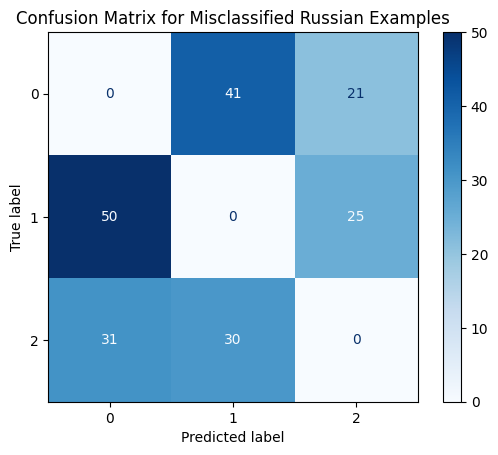

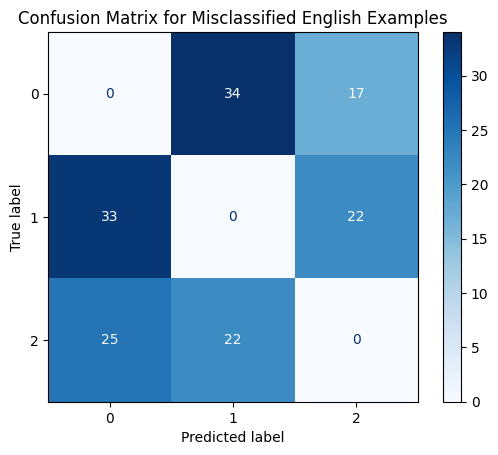

In [7]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm_ru = confusion_matrix(df_ru['true_label'], df_ru['predicted_label'])
disp = ConfusionMatrixDisplay(confusion_matrix=cm_ru)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix for Misclassified Russian Examples')
plt.show()

cm_en = confusion_matrix(df_en['true_label'], df_en['predicted_label'])
disp = ConfusionMatrixDisplay(confusion_matrix=cm_en)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix for Misclassified English Examples')
plt.show()

In [8]:
!python3 run.py \
    --model ./output_xnli_en_ru_bert_2/checkpoint-196352 \
    --task nli \
    --dataset facebook/xnli \
    --do_predict \
    --predict_file ./anli_R1_en_ru.jsonl \
    --output_dir ./output_xnli_en_ru_bert_2_test/anli_r1_test

2024-11-30 21:39:34.125723: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-30 21:39:34.139528: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-30 21:39:34.143515: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-30 21:39:34.153769: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-30 21:39:35.098772: W tensorflow/compiler/tf2

In [9]:
import pandas as pd
import json
df_ru = pd.read_json('output_xnli_en_ru_bert_2_test/anli_r1_test/misclassified_Russian.jsonl', lines=True)
df_en = pd.read_json('output_xnli_en_ru_bert_2_test/anli_r1_test/misclassified_English.jsonl', lines=True)
print(df_en['true_label'].value_counts())
print(df_ru['true_label'].value_counts())

true_label
2    265
1    238
0    226
Name: count, dtype: int64
true_label
2    264
1    231
0    228
Name: count, dtype: int64


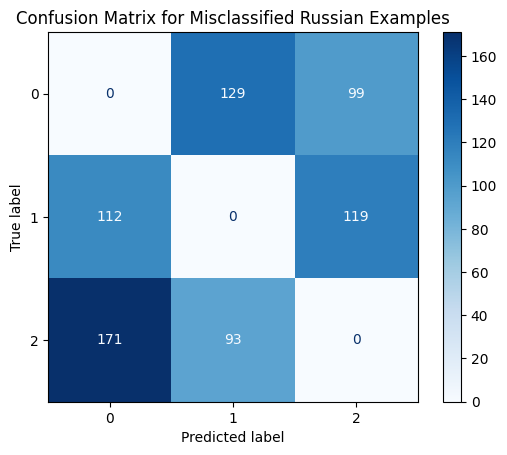

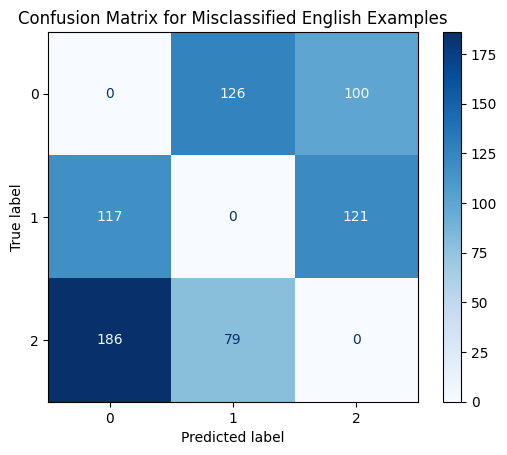

In [10]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm_ru = confusion_matrix(df_ru['true_label'], df_ru['predicted_label'])
disp = ConfusionMatrixDisplay(confusion_matrix=cm_ru)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix for Misclassified Russian Examples')
plt.show()

cm_en = confusion_matrix(df_en['true_label'], df_en['predicted_label'])
disp = ConfusionMatrixDisplay(confusion_matrix=cm_en)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix for Misclassified English Examples')
plt.show()

In [11]:
!python3 run.py \
    --model ./output_xnli_en_ru_bert_2/checkpoint-196352 \
    --task nli \
    --dataset facebook/xnli \
    --do_predict \
    --predict_file ./anli_R2_en_ru.jsonl \
    --output_dir ./output_xnli_en_ru_bert_2_test/anli_r2_test

2024-11-30 21:51:21.893965: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-30 21:51:21.907679: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-30 21:51:21.911724: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-30 21:51:21.921515: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-30 21:51:22.880199: W tensorflow/compiler/tf2

In [12]:
import pandas as pd
import json
df_ru = pd.read_json('output_xnli_en_ru_bert_2_test/anli_r2_test/misclassified_Russian.jsonl', lines=True)
df_en = pd.read_json('output_xnli_en_ru_bert_2_test/anli_r2_test/misclassified_English.jsonl', lines=True)
print(df_en['true_label'].value_counts())
print(df_ru['true_label'].value_counts())

true_label
2    233
1    223
0    221
Name: count, dtype: int64
true_label
1    225
0    224
2    223
Name: count, dtype: int64


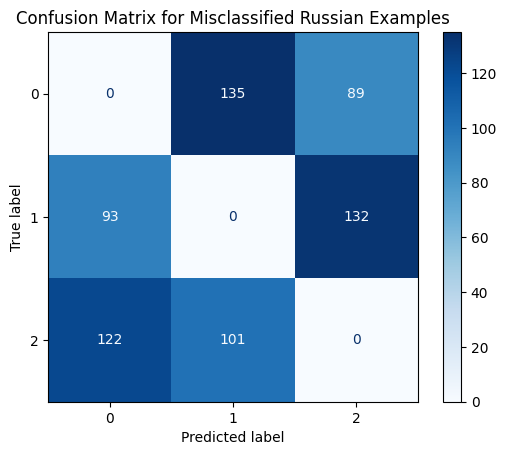

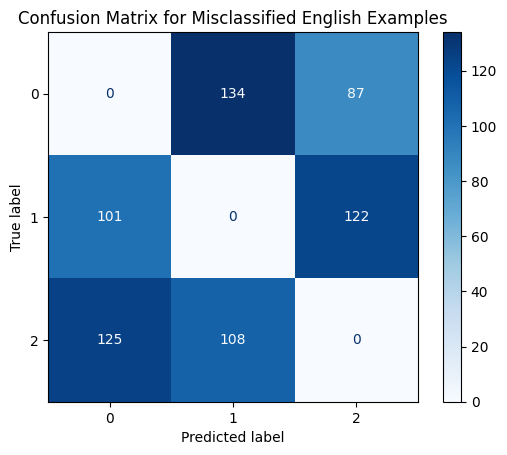

In [13]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm_ru = confusion_matrix(df_ru['true_label'], df_ru['predicted_label'])
disp = ConfusionMatrixDisplay(confusion_matrix=cm_ru)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix for Misclassified Russian Examples')
plt.show()

cm_en = confusion_matrix(df_en['true_label'], df_en['predicted_label'])
disp = ConfusionMatrixDisplay(confusion_matrix=cm_en)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix for Misclassified English Examples')
plt.show()

In [15]:
df_ru.to_csv('output_xnli_en_ru_bert_2_test/anli_r2_test/misclassified_Russian.csv', index=False)
df_en.to_csv('output_xnli_en_ru_bert_2_test/anli_r2_test/misclassified_English.csv', index=False)

In [4]:
!python3 run.py \
    --model ./output_xnli_en_ru_bert_2/checkpoint-196352 \
    --task nli \
    --dataset negation_examples_combined.jsonl \
    --do_train \
    --do_eval \
    --per_device_train_batch_size 16 \
    --num_train_epochs 5 \
    --evaluation_strategy='epoch' \
    --logging_strategy='epoch' \
    --save_strategy='epoch' \
    --output_dir ./output_anli_en_ru_bert_2/negation

2024-12-02 17:37:20.865694: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-02 17:37:20.882806: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-02 17:37:20.905108: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-02 17:37:20.911712: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-02 17:37:20.927810: I tensorflow/core/platform/cpu_feature_guar

In [15]:
!python3 run.py \
    --model ./output_anli_en_ru_bert_2/negation \
    --task nli \
    --dataset facebook/xnli \
    --do_predict \
    --predict_file ./anli_R2_en_ru.jsonl \
    --output_dir ./output_xnli_en_ru_bert_2_test/negation_anli_r2_test

2024-12-02 18:12:21.312091: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-02 18:12:21.328580: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-02 18:12:21.349403: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-02 18:12:21.355648: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-02 18:12:21.370600: I tensorflow/core/platform/cpu_feature_guar

In [16]:
!python3 run.py \
    --model ./output_anli_en_ru_bert_2/negation \
    --task nli \
    --dataset attribution_examples_combined.jsonl \
    --do_train \
    --do_eval \
    --per_device_train_batch_size 16 \
    --num_train_epochs 5 \
    --evaluation_strategy='epoch' \
    --logging_strategy='epoch' \
    --save_strategy='epoch' \
    --output_dir ./output_anli_en_ru_bert_2/negation_attribution

2024-12-02 18:15:38.781921: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-02 18:15:38.798957: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-02 18:15:38.819974: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-02 18:15:38.826522: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-02 18:15:38.842379: I tensorflow/core/platform/cpu_feature_guar

In [5]:
!python3 run.py \
    --model ./output_anli_en_ru_bert_2/negation_attribution \
    --task nli \
    --dataset facebook/xnli \
    --do_predict \
    --predict_file ./anli_R2_en_ru.jsonl \
    --output_dir ./output_xnli_en_ru_bert_2_test/negation_attribution_anli_r2_test

2024-12-02 18:51:01.863125: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-02 18:51:01.878524: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-02 18:51:01.883021: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-02 18:51:01.894120: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-12-02 18:51:03.112292: W tensorflow/compiler/tf2

In [4]:
!python3 run.py \
    --model ./output_xnli_en_ru_bert_2/checkpoint-196352 \
    --task nli \
    --dataset cointegrated/nli-rus-translated-v2021 \
    --source_filter anli_r1 \
    --do_train \
    --do_eval \
    --per_device_train_batch_size 16 \
    --num_train_epochs 5 \
    --evaluation_strategy='epoch' \
    --logging_strategy='epoch' \
    --save_strategy='epoch' \
    --output_dir ./output_anli_en_ru_bert_2/r1

2024-12-02 19:16:44.343531: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-02 19:16:44.359914: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-02 19:16:44.380883: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-02 19:16:44.387229: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-02 19:16:44.402531: I tensorflow/core/platform/cpu_feature_guar

In [5]:
!python3 run.py \
    --model ./output_anli_en_ru_bert_2/r1/checkpoint-8476 \
    --task nli \
    --dataset cointegrated/nli-rus-translated-v2021 \
    --source_filter anli_r2 \
    --do_train \
    --do_eval \
    --per_device_train_batch_size 16 \
    --num_train_epochs 5 \
    --evaluation_strategy='epoch' \
    --logging_strategy='epoch' \
    --save_strategy='epoch' \
    --output_dir ./output_anli_en_ru_bert_2/r2

2024-12-02 19:42:24.528048: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-02 19:42:24.545395: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-02 19:42:24.566916: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-02 19:42:24.573458: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-02 19:42:24.589568: I tensorflow/core/platform/cpu_feature_guar

In [6]:
!python3 run.py \
    --model ./output_anli_en_ru_bert_2/r2/checkpoint-22732 \
    --task nli \
    --dataset cointegrated/nli-rus-translated-v2021 \
    --source_filter anli_r3 \
    --do_train \
    --do_eval \
    --per_device_train_batch_size 16 \
    --num_train_epochs 5 \
    --evaluation_strategy='epoch' \
    --logging_strategy='epoch' \
    --save_strategy='epoch' \
    --output_dir ./output_anli_en_ru_bert_2/r3

2024-12-02 20:30:41.221120: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-02 20:30:41.238222: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-02 20:30:41.259261: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-02 20:30:41.265594: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-02 20:30:41.281033: I tensorflow/core/platform/cpu_feature_guar

In [7]:
!python3 run.py \
    --model ./output_anli_en_ru_bert_2/r3/checkpoint-62790 \
    --task nli \
    --dataset negation_examples_comb.jsonl \
    --do_train \
    --do_eval \
    --per_device_train_batch_size 16 \
    --num_train_epochs 5 \
    --evaluation_strategy='epoch' \
    --logging_strategy='epoch' \
    --save_strategy='epoch' \
    --output_dir ./output_anli_en_ru_bert_2/negation

2024-12-02 22:23:36.395096: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-02 22:23:36.411856: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-02 22:23:36.432644: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-02 22:23:36.438972: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-02 22:23:36.454220: I tensorflow/core/platform/cpu_feature_guar

In [8]:
!python3 run.py \
    --model ./output_anli_en_ru_bert_2/negation/checkpoint-2118 \
    --task nli \
    --dataset attribution_examples_comb.jsonl \
    --do_train \
    --do_eval \
    --per_device_train_batch_size 16 \
    --num_train_epochs 5 \
    --evaluation_strategy='epoch' \
    --logging_strategy='epoch' \
    --save_strategy='epoch' \
    --output_dir ./output_anli_en_ru_bert_2/attribution

2024-12-02 22:43:54.615690: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-02 22:43:54.633278: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-02 22:43:54.654881: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-02 22:43:54.661368: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-02 22:43:54.677837: I tensorflow/core/platform/cpu_feature_guar

In [9]:
!python3 run.py \
    --model ./output_anli_en_ru_bert_2/attribution/checkpoint-5268 \
    --task nli \
    --dataset high_overlap_examples_comb.jsonl \
    --do_train \
    --do_eval \
    --per_device_train_batch_size 16 \
    --num_train_epochs 5 \
    --evaluation_strategy='epoch' \
    --logging_strategy='epoch' \
    --save_strategy='epoch' \
    --output_dir ./output_anli_en_ru_bert_2/high_overlap

2024-12-02 23:00:17.420242: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-02 23:00:17.437507: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-02 23:00:17.458691: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-02 23:00:17.465117: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-02 23:00:17.481111: I tensorflow/core/platform/cpu_feature_guar

In [4]:
!python3 run.py \
    --model ./output_anli_en_ru_bert_2/r1/checkpoint-8476 \
    --task nli \
    --dataset facebook/xnli \
    --do_predict \
    --predict_file ./anli_R1_en_ru.jsonl \
    --output_dir ./output_xnli_en_ru_bert_2_test/anli_r1_model_testing/anli_r1_test

2024-12-02 23:10:07.347492: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-02 23:10:07.361245: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-02 23:10:07.365363: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-02 23:10:07.375668: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-12-02 23:10:08.557725: W tensorflow/compiler/tf2

In [5]:
!python3 run.py \
    --model ./output_anli_en_ru_bert_2/r1/checkpoint-8476 \
    --task nli \
    --dataset facebook/xnli \
    --do_predict \
    --predict_file ./anli_R2_en_ru.jsonl \
    --output_dir ./output_xnli_en_ru_bert_2_test/anli_r1_model_testing/anli_r2_test

2024-12-02 23:22:42.428293: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-02 23:22:42.442728: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-02 23:22:42.446722: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-02 23:22:42.456693: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-12-02 23:22:43.390149: W tensorflow/compiler/tf2

In [6]:
!python3 run.py \
    --model ./output_anli_en_ru_bert_2/r1/checkpoint-8476 \
    --task nli \
    --dataset facebook/xnli \
    --do_predict \
    --predict_file ./anli_R3_en_ru.jsonl \
    --output_dir ./output_xnli_en_ru_bert_2_test/anli_r1_model_testing/anli_r3_test

2024-12-02 23:33:42.445575: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-02 23:33:42.459174: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-02 23:33:42.464076: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-02 23:33:42.474207: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-12-02 23:33:43.413811: W tensorflow/compiler/tf2

In [8]:
!python3 run.py \
    --model ./output_anli_en_ru_bert_2/r1/checkpoint-8476 \
    --task nli \
    --dataset facebook/xnli \
    --do_predict \
    --output_dir ./output_xnli_en_ru_bert_2_test/anli_r1_model_testing/xnli_test

2024-12-02 23:49:53.688928: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-02 23:49:53.702791: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-02 23:49:53.706823: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-02 23:49:53.716849: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-12-02 23:49:54.681856: W tensorflow/compiler/tf2

In [10]:
!python3 run.py \
    --model ./output_anli_en_ru_bert_2/r2/checkpoint-22732 \
    --task nli \
    --dataset facebook/xnli \
    --do_predict \
    --output_dir ./output_xnli_en_ru_bert_2_test/anli_r2_model_testing/xnli_test

2024-12-03 01:17:29.684574: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-03 01:17:29.699497: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-03 01:17:29.703534: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-03 01:17:29.714171: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-12-03 01:17:30.721661: W tensorflow/compiler/tf2

In [11]:
!python3 run.py \
    --model ./output_anli_en_ru_bert_2/r2/checkpoint-22732 \
    --task nli \
    --dataset facebook/xnli \
    --do_predict \
    --predict_file ./anli_R3_en_ru.jsonl \
    --output_dir ./output_xnli_en_ru_bert_2_test/anli_r2_model_testing/anli_r3_test

2024-12-03 02:08:09.620002: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-03 02:08:09.634307: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-03 02:08:09.638375: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-03 02:08:09.648533: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-12-03 02:08:10.593907: W tensorflow/compiler/tf2

In [12]:
!python3 run.py \
    --model ./output_anli_en_ru_bert_2/r2/checkpoint-22732 \
    --task nli \
    --dataset facebook/xnli \
    --do_predict \
    --predict_file ./anli_R2_en_ru.jsonl \
    --output_dir ./output_xnli_en_ru_bert_2_test/anli_r2_model_testing/anli_r2_test

2024-12-03 02:20:23.041790: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-03 02:20:23.057500: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-03 02:20:23.061630: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-03 02:20:23.072138: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-12-03 02:20:24.057480: W tensorflow/compiler/tf2

In [13]:
!python3 run.py \
    --model ./output_anli_en_ru_bert_2/r2/checkpoint-22732 \
    --task nli \
    --dataset facebook/xnli \
    --do_predict \
    --predict_file ./anli_R1_en_ru.jsonl \
    --output_dir ./output_xnli_en_ru_bert_2_test/anli_r2_model_testing/anli_r1_test

2024-12-03 02:31:15.378280: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-03 02:31:15.392732: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-03 02:31:15.396706: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-03 02:31:15.407404: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-12-03 02:31:16.356448: W tensorflow/compiler/tf2

In [14]:
!python3 run.py \
    --model ./output_anli_en_ru_bert_2/r3/checkpoint-62790 \
    --task nli \
    --dataset facebook/xnli \
    --do_predict \
    --output_dir ./output_xnli_en_ru_bert_2_test/anli_r3_model_testing/xnli_test

2024-12-03 02:41:33.630797: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-03 02:41:33.645156: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-03 02:41:33.649212: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-03 02:41:33.659571: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-12-03 02:41:34.654942: W tensorflow/compiler/tf2

In [15]:
!python3 run.py \
    --model ./output_anli_en_ru_bert_2/r3/checkpoint-62790 \
    --task nli \
    --dataset facebook/xnli \
    --do_predict \
    --predict_file ./anli_R1_en_ru.jsonl \
    --output_dir ./output_xnli_en_ru_bert_2_test/anli_r3_model_testing/anli_r1_test

2024-12-03 03:31:41.394208: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-03 03:31:41.408726: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-03 03:31:41.412884: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-03 03:31:41.423403: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-12-03 03:31:42.422929: W tensorflow/compiler/tf2

In [16]:
!python3 run.py \
    --model ./output_anli_en_ru_bert_2/r3/checkpoint-62790 \
    --task nli \
    --dataset facebook/xnli \
    --do_predict \
    --predict_file ./anli_R2_en_ru.jsonl \
    --output_dir ./output_xnli_en_ru_bert_2_test/anli_r3_model_testing/anli_r2_test

2024-12-03 03:42:29.584550: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-03 03:42:29.599279: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-03 03:42:29.603399: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-03 03:42:29.613864: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-12-03 03:42:30.592061: W tensorflow/compiler/tf2

In [17]:
!python3 run.py \
    --model ./output_anli_en_ru_bert_2/r3/checkpoint-62790 \
    --task nli \
    --dataset facebook/xnli \
    --do_predict \
    --predict_file ./anli_R3_en_ru.jsonl \
    --output_dir ./output_xnli_en_ru_bert_2_test/anli_r3_model_testing/anli_r3_test

2024-12-03 03:53:09.840956: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-03 03:53:09.855659: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-03 03:53:09.859804: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-03 03:53:09.870452: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-12-03 03:53:10.858696: W tensorflow/compiler/tf2

In [18]:
!python3 run.py \
    --model ./output_anli_en_ru_bert_2/negation/checkpoint-2118 \
    --task nli \
    --dataset facebook/xnli \
    --do_predict \
    --output_dir ./output_xnli_en_ru_bert_2_test/negation_testing/xnli_test

2024-12-03 04:58:19.205715: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-03 04:58:19.219755: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-03 04:58:19.223781: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-03 04:58:19.234093: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-12-03 04:58:20.202137: W tensorflow/compiler/tf2

In [19]:
!python3 run.py \
    --model ./output_anli_en_ru_bert_2/negation/checkpoint-2118 \
    --task nli \
    --dataset facebook/xnli \
    --do_predict \
    --predict_file ./anli_R3_en_ru.jsonl \
    --output_dir ./output_xnli_en_ru_bert_2_test/negation_testing/anli_r3_test

2024-12-03 05:48:23.634715: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-03 05:48:23.648979: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-03 05:48:23.653000: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-03 05:48:23.663052: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-12-03 05:48:24.644052: W tensorflow/compiler/tf2

In [20]:
!python3 run.py \
    --model ./output_anli_en_ru_bert_2/negation/checkpoint-2118 \
    --task nli \
    --dataset facebook/xnli \
    --do_predict \
    --predict_file ./anli_R2_en_ru.jsonl \
    --output_dir ./output_xnli_en_ru_bert_2_test/negation_testing/anli_r2_test

2024-12-03 06:01:04.800138: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-03 06:01:04.814125: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-03 06:01:04.818098: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-03 06:01:04.828517: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-12-03 06:01:05.786693: W tensorflow/compiler/tf2

In [21]:
!python3 run.py \
    --model ./output_anli_en_ru_bert_2/negation/checkpoint-2118 \
    --task nli \
    --dataset facebook/xnli \
    --do_predict \
    --predict_file ./anli_R1_en_ru.jsonl \
    --output_dir ./output_xnli_en_ru_bert_2_test/negation_testing/anli_r1_test

2024-12-03 06:11:19.088816: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-03 06:11:19.103392: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-03 06:11:19.107512: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-03 06:11:19.117929: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-12-03 06:11:20.081729: W tensorflow/compiler/tf2

In [22]:
!python3 run.py \
    --model ./output_anli_en_ru_bert_2/attribution/checkpoint-5268 \
    --task nli \
    --dataset facebook/xnli \
    --do_predict \
    --output_dir ./output_xnli_en_ru_bert_2_test/attribution_testing/xnli_test

2024-12-03 06:21:30.352140: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-03 06:21:30.367893: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-03 06:21:30.372123: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-03 06:21:30.382906: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-12-03 06:21:31.389862: W tensorflow/compiler/tf2

In [23]:
!python3 run.py \
    --model ./output_anli_en_ru_bert_2/attribution/checkpoint-5268 \
    --task nli \
    --dataset facebook/xnli \
    --do_predict \
    --predict_file ./anli_R1_en_ru.jsonl \
    --output_dir ./output_xnli_en_ru_bert_2_test/attribution_testing/anli_r1_test

2024-12-03 07:10:57.494635: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-03 07:10:57.511472: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-03 07:10:57.517042: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-03 07:10:57.535842: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-12-03 07:10:58.519827: W tensorflow/compiler/tf2

In [24]:
!python3 run.py \
    --model ./output_anli_en_ru_bert_2/attribution/checkpoint-5268 \
    --task nli \
    --dataset facebook/xnli \
    --do_predict \
    --predict_file ./anli_R2_en_ru.jsonl \
    --output_dir ./output_xnli_en_ru_bert_2_test/attribution_testing/anli_r2_test

2024-12-03 07:20:57.678328: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-03 07:20:57.692478: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-03 07:20:57.696498: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-03 07:20:57.706573: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-12-03 07:20:58.649851: W tensorflow/compiler/tf2

In [25]:
!python3 run.py \
    --model ./output_anli_en_ru_bert_2/attribution/checkpoint-5268 \
    --task nli \
    --dataset facebook/xnli \
    --do_predict \
    --predict_file ./anli_R3_en_ru.jsonl \
    --output_dir ./output_xnli_en_ru_bert_2_test/attribution_testing/anli_r3_test

2024-12-03 07:31:58.089697: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-03 07:31:58.105186: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-03 07:31:58.110204: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-03 07:31:58.122897: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-12-03 07:31:59.188923: W tensorflow/compiler/tf2

In [26]:
!python3 run.py \
    --model ./output_anli_en_ru_bert_2/high_overlap/checkpoint-199 \
    --task nli \
    --dataset facebook/xnli \
    --do_predict \
    --output_dir ./output_xnli_en_ru_bert_2_test/high_overlap_testing/xnli_test

2024-12-03 07:46:07.532170: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-03 07:46:07.546794: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-03 07:46:07.551312: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-03 07:46:07.562109: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-12-03 07:46:08.665663: W tensorflow/compiler/tf2

In [27]:
!python3 run.py \
    --model ./output_anli_en_ru_bert_2/high_overlap/checkpoint-199 \
    --task nli \
    --dataset facebook/xnli \
    --do_predict \
    --predict_file ./anli_R1_en_ru.jsonl \
    --output_dir ./output_xnli_en_ru_bert_2_test/high_overlap_testing/anli_r1_test

2024-12-03 08:45:44.020122: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-03 08:45:44.037288: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-03 08:45:44.043062: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-03 08:45:44.061846: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-12-03 08:45:45.135241: W tensorflow/compiler/tf2

In [28]:
!python3 run.py \
    --model ./output_anli_en_ru_bert_2/high_overlap/checkpoint-199 \
    --task nli \
    --dataset facebook/xnli \
    --do_predict \
    --predict_file ./anli_R2_en_ru.jsonl \
    --output_dir ./output_xnli_en_ru_bert_2_test/high_overlap_testing/anli_r2_test

2024-12-03 08:57:16.825416: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-03 08:57:16.840952: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-03 08:57:16.845124: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-03 08:57:16.855835: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-12-03 08:57:17.881207: W tensorflow/compiler/tf2

In [29]:
!python3 run.py \
    --model ./output_anli_en_ru_bert_2/high_overlap/checkpoint-199 \
    --task nli \
    --dataset facebook/xnli \
    --do_predict \
    --predict_file ./anli_R3_en_ru.jsonl \
    --output_dir ./output_xnli_en_ru_bert_2_test/high_overlap_testing/anli_r3_test

2024-12-03 09:09:22.857846: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-03 09:09:22.873657: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-03 09:09:22.878126: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-03 09:09:22.889548: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-12-03 09:09:23.903712: W tensorflow/compiler/tf2

Training with Metaphors first then ANLI one epoch each

In [5]:
!python3 run.py \
    --model ./output_xnli_en_ru_bert_2/checkpoint-196352 \
    --task nli \
    --dataset metaphor_training.jsonl \
    --do_train \
    --do_eval \
    --per_device_train_batch_size 16 \
    --num_train_epochs 5 \
    --evaluation_strategy='epoch' \
    --logging_strategy='epoch' \
    --save_strategy='epoch' \
    --output_dir ./output_anli_en_ru_bert_2/metaphor

2024-12-03 19:16:57.558346: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-03 19:16:57.574330: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-03 19:16:57.595591: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-03 19:16:57.601957: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-03 19:16:57.617180: I tensorflow/core/platform/cpu_feature_guar

In [6]:
!python3 run.py \
    --model ./output_anli_en_ru_bert_2/metaphor/checkpoint-363 \
    --task nli \
    --dataset facebook/xnli \
    --do_predict \
    --output_dir ./output_xnli_en_ru_bert_2_test/metaphor_model_testing/xnli_test

2024-12-03 19:21:29.377633: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-03 19:21:29.394490: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-03 19:21:29.415427: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-03 19:21:29.421776: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-03 19:21:29.436725: I tensorflow/core/platform/cpu_feature_guar

In [7]:
!python3 run.py \
    --model ./output_anli_en_ru_bert_2/metaphor/checkpoint-363 \
    --task nli \
    --dataset facebook/xnli \
    --do_predict \
    --predict_file ./anli_R2_en_ru.jsonl \
    --output_dir ./output_xnli_en_ru_bert_2_test/metaphor_model_testing/anli_r2_test

2024-12-03 19:24:08.907870: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-03 19:24:08.924280: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-03 19:24:08.945277: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-03 19:24:08.951597: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-03 19:24:08.966612: I tensorflow/core/platform/cpu_feature_guar

In [8]:
!python3 run.py \
    --model ./output_anli_en_ru_bert_2/metaphor/checkpoint-363 \
    --task nli \
    --dataset facebook/xnli \
    --do_predict \
    --predict_file ./anli_R1_en_ru.jsonl \
    --output_dir ./output_xnli_en_ru_bert_2_test/metaphor_model_testing/anli_r1_test

2024-12-03 19:24:40.083934: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-03 19:24:40.100674: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-03 19:24:40.121934: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-03 19:24:40.128371: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-03 19:24:40.144210: I tensorflow/core/platform/cpu_feature_guar

In [9]:
!python3 run.py \
    --model ./output_anli_en_ru_bert_2/metaphor/checkpoint-363 \
    --task nli \
    --dataset facebook/xnli \
    --do_predict \
    --predict_file ./anli_R3_en_ru.jsonl \
    --output_dir ./output_xnli_en_ru_bert_2_test/metaphor_model_testing/anli_r3_test

2024-12-03 19:25:16.207972: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-03 19:25:16.223905: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-03 19:25:16.244360: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-03 19:25:16.250549: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-03 19:25:16.265054: I tensorflow/core/platform/cpu_feature_guar

In [17]:
!python3 run.py \
    --model ./output_anli_en_ru_bert_2/metaphor/checkpoint-363 \
    --task nli \
    --dataset adversarial_shuffle.jsonl \
    --do_train \
    --per_device_train_batch_size 16 \
    --num_train_epochs 1 \
    --evaluation_strategy='epoch' \
    --logging_strategy='epoch' \
    --save_strategy='epoch' \
    --output_dir ./output_anli_en_ru_bert_2/metaphor_shuffle

2024-12-03 20:49:38.890741: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-03 20:49:38.907724: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-03 20:49:38.928790: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-03 20:49:38.935157: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-03 20:49:38.950487: I tensorflow/core/platform/cpu_feature_guar

In [19]:
!python3 run.py \
    --model ./output_anli_en_ru_bert_2/metaphor_shuffle/checkpoint-75 \
    --task nli \
    --dataset facebook/xnli \
    --do_predict \
    --predict_file ./anli_R3_en_ru.jsonl \
    --output_dir ./output_xnli_en_ru_bert_2_test/metaphor_shuffle_testing/anli_r3_test

2024-12-03 20:51:19.862748: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-03 20:51:19.879102: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-03 20:51:19.900059: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-03 20:51:19.906388: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-03 20:51:19.921359: I tensorflow/core/platform/cpu_feature_guar

In [20]:
!python3 run.py \
    --model ./output_anli_en_ru_bert_2/metaphor_shuffle/checkpoint-75 \
    --task nli \
    --dataset adversarial_premise.jsonl \
    --do_train \
    --per_device_train_batch_size 16 \
    --num_train_epochs 1 \
    --evaluation_strategy='epoch' \
    --logging_strategy='epoch' \
    --save_strategy='epoch' \
    --output_dir ./output_anli_en_ru_bert_2/metaphor_shuffle_premise

2024-12-03 20:53:47.271931: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-03 20:53:47.297681: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-03 20:53:47.320511: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-03 20:53:47.327111: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-03 20:53:47.343489: I tensorflow/core/platform/cpu_feature_guar

In [21]:
!python3 run.py \
    --model ./output_anli_en_ru_bert_2/metaphor_shuffle_premise/checkpoint-60 \
    --task nli \
    --dataset facebook/xnli \
    --do_predict \
    --predict_file ./anli_R3_en_ru.jsonl \
    --output_dir ./output_xnli_en_ru_bert_2_test/metaphor_shuffle_premise_testing/anli_r3_test

2024-12-03 20:57:04.914365: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-03 20:57:04.931439: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-03 20:57:04.953016: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-03 20:57:04.959414: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-03 20:57:04.974780: I tensorflow/core/platform/cpu_feature_guar

Strategy Reset: Below is final train test strategy. Starting with testing XNLI on Metaphors and ANLI, then training on Metaphors, then training on ANLI error sets

In [23]:
!python3 run.py \
    --model ./output_xnli_en_ru_bert_2/checkpoint-196352 \
    --task nli \
    --dataset facebook/xnli \
    --do_predict \
    --predict_file ./metaphor_test.jsonl \
    --output_dir ./output_xnli_en_ru_bert_2_test/xnli_model_testing/metaphor_final

2024-12-03 21:38:59.065138: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-03 21:38:59.082326: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-03 21:38:59.103544: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-03 21:38:59.109981: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-03 21:38:59.125366: I tensorflow/core/platform/cpu_feature_guar

In [24]:
!python3 run.py \
    --model ./output_xnli_en_ru_bert_2/checkpoint-196352 \
    --task nli \
    --dataset facebook/xnli \
    --do_predict \
    --predict_file ./anli_test.jsonl \
    --output_dir ./output_xnli_en_ru_bert_2_test/xnli_model_testing/anli_final

2024-12-03 21:39:38.041600: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-03 21:39:38.058194: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-03 21:39:38.078768: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-03 21:39:38.085005: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-03 21:39:38.099620: I tensorflow/core/platform/cpu_feature_guar

In [25]:
!python3 run.py \
    --model ./output_xnli_en_ru_bert_2/checkpoint-196352 \
    --task nli \
    --dataset facebook/xnli \
    --do_predict \
    --predict_file ./final_test.jsonl \
    --output_dir ./output_xnli_en_ru_bert_2_test/xnli_model_testing/comb_final

2024-12-03 21:40:40.504773: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-03 21:40:40.521331: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-03 21:40:40.542221: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-03 21:40:40.548582: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-03 21:40:40.563680: I tensorflow/core/platform/cpu_feature_guar

In [26]:
!python3 run.py \
    --model ./output_xnli_en_ru_bert_2/checkpoint-196352 \
    --task nli \
    --dataset metaphor_training_final.jsonl \
    --do_train \
    --do_eval \
    --per_device_train_batch_size 16 \
    --num_train_epochs 5 \
    --evaluation_strategy='epoch' \
    --logging_strategy='epoch' \
    --save_strategy='epoch' \
    --output_dir ./output_metaphor_anli_final/metaphor

2024-12-03 21:45:48.831440: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-03 21:45:48.848792: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-03 21:45:48.870353: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-03 21:45:48.876873: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-03 21:45:48.892553: I tensorflow/core/platform/cpu_feature_guar

In [27]:
!python3 run.py \
    --model ./output_metaphor_anli_final/metaphor/checkpoint-273 \
    --task nli \
    --dataset facebook/xnli \
    --do_predict \
    --predict_file ./metaphor_test.jsonl \
    --output_dir ./output_xnli_en_ru_bert_2_test/xnli_metaphor_model_testing/metaphor_final

2024-12-03 21:49:13.741737: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-03 21:49:13.758879: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-03 21:49:13.780162: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-03 21:49:13.786658: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-03 21:49:13.801970: I tensorflow/core/platform/cpu_feature_guar

In [28]:
!python3 run.py \
    --model ./output_metaphor_anli_final/metaphor/checkpoint-273 \
    --task nli \
    --dataset facebook/xnli \
    --do_predict \
    --predict_file ./anli_test.jsonl \
    --output_dir ./output_xnli_en_ru_bert_2_test/xnli_metaphor_model_testing/anli_final

2024-12-03 21:50:14.597350: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-03 21:50:14.614341: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-03 21:50:14.635435: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-03 21:50:14.641890: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-03 21:50:14.657345: I tensorflow/core/platform/cpu_feature_guar

In [29]:
!python3 run.py \
    --model ./output_metaphor_anli_final/metaphor/checkpoint-273 \
    --task nli \
    --dataset facebook/xnli \
    --do_predict \
    --predict_file ./final_test.jsonl \
    --output_dir ./output_xnli_en_ru_bert_2_test/xnli_metaphor_model_testing/comb_final

2024-12-03 21:51:41.898660: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-03 21:51:41.915858: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-03 21:51:41.936521: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-03 21:51:41.942864: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-03 21:51:41.958536: I tensorflow/core/platform/cpu_feature_guar

In [30]:
!python3 run.py \
    --model ./output_metaphor_anli_final/metaphor/checkpoint-273 \
    --task nli \
    --dataset negation_examples_comb.jsonl \
    --do_train \
    --do_eval \
    --per_device_train_batch_size 16 \
    --num_train_epochs 5 \
    --evaluation_strategy='epoch' \
    --logging_strategy='epoch' \
    --save_strategy='epoch' \
    --output_dir ./output_metaphor_anli_final/metaphor_negation

2024-12-03 21:54:58.204097: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-03 21:54:58.221300: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-03 21:54:58.242416: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-03 21:54:58.248874: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-03 21:54:58.264740: I tensorflow/core/platform/cpu_feature_guar

In [31]:
!python3 run.py \
    --model ./output_metaphor_anli_final/metaphor_negation/checkpoint-2118 \
    --task nli \
    --dataset facebook/xnli \
    --do_predict \
    --predict_file ./metaphor_test.jsonl \
    --output_dir ./output_xnli_en_ru_bert_2_test/xnli_metaphor_negation_model_testing/metaphor_final

2024-12-03 22:13:19.073057: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-03 22:13:19.089554: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-03 22:13:19.110707: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-03 22:13:19.117070: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-03 22:13:19.132085: I tensorflow/core/platform/cpu_feature_guar

In [32]:
!python3 run.py \
    --model ./output_metaphor_anli_final/metaphor_negation/checkpoint-2118 \
    --task nli \
    --dataset facebook/xnli \
    --do_predict \
    --predict_file ./anli_test.jsonl \
    --output_dir ./output_xnli_en_ru_bert_2_test/xnli_metaphor_negation_model_testing/anli_final

2024-12-03 22:13:38.798861: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-03 22:13:38.815451: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-03 22:13:38.836757: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-03 22:13:38.843091: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-03 22:13:38.858185: I tensorflow/core/platform/cpu_feature_guar

In [33]:
!python3 run.py \
    --model ./output_metaphor_anli_final/metaphor_negation/checkpoint-2118 \
    --task nli \
    --dataset facebook/xnli \
    --do_predict \
    --predict_file ./final_test.jsonl \
    --output_dir ./output_xnli_en_ru_bert_2_test/xnli_metaphor_negation_model_testing/comb_final

2024-12-03 22:14:41.230604: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-03 22:14:41.248037: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-03 22:14:41.269749: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-03 22:14:41.276309: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-03 22:14:41.292377: I tensorflow/core/platform/cpu_feature_guar

In [34]:
!python3 run.py \
    --model ./output_metaphor_anli_final/metaphor_negation/checkpoint-2118 \
    --task nli \
    --dataset attribution_examples_comb.jsonl \
    --do_train \
    --do_eval \
    --per_device_train_batch_size 16 \
    --num_train_epochs 5 \
    --evaluation_strategy='epoch' \
    --logging_strategy='epoch' \
    --save_strategy='epoch' \
    --output_dir ./output_metaphor_anli_final/metaphor_negation_attribution

2024-12-03 22:15:46.019549: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-03 22:15:46.036049: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-03 22:15:46.057022: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-03 22:15:46.063339: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-03 22:15:46.078166: I tensorflow/core/platform/cpu_feature_guar

In [35]:
!python3 run.py \
    --model ./output_metaphor_anli_final/metaphor_negation_attribution/checkpoint-1756 \
    --task nli \
    --dataset facebook/xnli \
    --do_predict \
    --predict_file ./metaphor_test.jsonl \
    --output_dir ./output_xnli_en_ru_bert_2_test/xnli_metaphor_negation_attribution_model_testing/metaphor_final

2024-12-03 22:31:45.688523: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-03 22:31:45.705858: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-03 22:31:45.728308: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-03 22:31:45.735072: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-03 22:31:45.751530: I tensorflow/core/platform/cpu_feature_guar

In [36]:
!python3 run.py \
    --model ./output_metaphor_anli_final/metaphor_negation_attribution/checkpoint-1756 \
    --task nli \
    --dataset facebook/xnli \
    --do_predict \
    --predict_file ./anli_test.jsonl \
    --output_dir ./output_xnli_en_ru_bert_2_test/xnli_metaphor_negation_attribution_model_testing/anli_final

2024-12-03 22:32:05.234317: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-03 22:32:05.251346: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-03 22:32:05.272900: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-03 22:32:05.279283: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-03 22:32:05.294184: I tensorflow/core/platform/cpu_feature_guar

In [37]:
!python3 run.py \
    --model ./output_metaphor_anli_final/metaphor_negation_attribution/checkpoint-1756 \
    --task nli \
    --dataset facebook/xnli \
    --do_predict \
    --predict_file ./final_test.jsonl \
    --output_dir ./output_xnli_en_ru_bert_2_test/xnli_metaphor_negation_attribution_model_testing/comb_final

2024-12-03 22:33:07.440673: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-03 22:33:07.458598: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-03 22:33:07.480054: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-03 22:33:07.486523: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-03 22:33:07.503224: I tensorflow/core/platform/cpu_feature_guar

In [38]:
!python3 run.py \
    --model ./output_metaphor_anli_final/metaphor_negation_attribution/checkpoint-1756 \
    --task nli \
    --dataset high_overlap_examples_comb.jsonl \
    --do_train \
    --do_eval \
    --per_device_train_batch_size 16 \
    --num_train_epochs 5 \
    --evaluation_strategy='epoch' \
    --logging_strategy='epoch' \
    --save_strategy='epoch' \
    --output_dir ./output_metaphor_anli_final/metaphor_negation_attribution_overlap

2024-12-03 22:34:11.597981: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-03 22:34:11.614543: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-03 22:34:11.635514: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-03 22:34:11.641873: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-03 22:34:11.656953: I tensorflow/core/platform/cpu_feature_guar

In [39]:
!python3 run.py \
    --model ./output_metaphor_anli_final/metaphor_negation_attribution_overlap/checkpoint-199 \
    --task nli \
    --dataset facebook/xnli \
    --do_predict \
    --predict_file ./metaphor_test.jsonl \
    --output_dir ./output_xnli_en_ru_bert_2_test/xnli_metaphor_negation_attribution_overlap_model_testing/metaphor_final

2024-12-03 22:38:52.754904: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-03 22:38:52.772276: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-03 22:38:52.793760: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-03 22:38:52.800540: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-03 22:38:52.816463: I tensorflow/core/platform/cpu_feature_guar

In [40]:
!python3 run.py \
    --model ./output_metaphor_anli_final/metaphor_negation_attribution_overlap/checkpoint-199 \
    --task nli \
    --dataset facebook/xnli \
    --do_predict \
    --predict_file ./anli_test.jsonl \
    --output_dir ./output_xnli_en_ru_bert_2_test/xnli_metaphor_negation_attribution_overlap_model_testing/anli_final

2024-12-03 22:39:11.861944: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-03 22:39:11.878909: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-03 22:39:11.899928: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-03 22:39:11.906282: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-03 22:39:11.921416: I tensorflow/core/platform/cpu_feature_guar

In [41]:
!python3 run.py \
    --model ./output_metaphor_anli_final/metaphor_negation_attribution_overlap/checkpoint-199 \
    --task nli \
    --dataset facebook/xnli \
    --do_predict \
    --predict_file ./final_test.jsonl \
    --output_dir ./output_xnli_en_ru_bert_2_test/xnli_metaphor_negation_attribution_overlap_model_testing/comb_final

2024-12-03 22:40:13.190912: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-03 22:40:13.209233: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-03 22:40:13.231209: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-03 22:40:13.237661: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-03 22:40:13.254146: I tensorflow/core/platform/cpu_feature_guar

In [43]:
!python3 run.py \
    --model ./output_xnli_en_ru_bert_2/checkpoint-196352 \
    --task nli \
    --dataset final_train.jsonl \
    --do_train \
    --do_eval \
    --per_device_train_batch_size 16 \
    --num_train_epochs 5 \
    --evaluation_strategy='epoch' \
    --logging_strategy='epoch' \
    --save_strategy='epoch' \
    --output_dir ./output_metaphor_anli_final/comb

2024-12-03 22:45:31.366913: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-03 22:45:31.383959: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-03 22:45:31.404959: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-03 22:45:31.411327: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-03 22:45:31.426561: I tensorflow/core/platform/cpu_feature_guar

In [47]:
!python3 run.py \
    --model ./output_metaphor_anli_final/comb/checkpoint-20810 \
    --task nli \
    --dataset facebook/xnli \
    --do_predict \
    --predict_file ./final_test.jsonl \
    --output_dir ./output_xnli_en_ru_bert_2_test/xnli_comb/comb_final

2024-12-03 23:26:54.546468: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-03 23:26:54.563603: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-03 23:26:54.584890: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-03 23:26:54.591499: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-03 23:26:54.606901: I tensorflow/core/platform/cpu_feature_guar

In [48]:
!python3 run.py \
    --model ./output_metaphor_anli_final/comb/checkpoint-20810 \
    --task nli \
    --dataset facebook/xnli \
    --do_predict \
    --predict_file ./anli_test.jsonl \
    --output_dir ./output_xnli_en_ru_bert_2_test/xnli_comb/anli_final

2024-12-03 23:28:00.091786: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-03 23:28:00.108414: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-03 23:28:00.129409: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-03 23:28:00.135774: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-03 23:28:00.150835: I tensorflow/core/platform/cpu_feature_guar

In [49]:
!python3 run.py \
    --model ./output_metaphor_anli_final/comb/checkpoint-20810 \
    --task nli \
    --dataset facebook/xnli \
    --do_predict \
    --predict_file ./metaphor_test.jsonl \
    --output_dir ./output_xnli_en_ru_bert_2_test/xnli_comb/metaphor_final

2024-12-03 23:29:01.287485: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-03 23:29:01.304590: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-03 23:29:01.325877: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-03 23:29:01.332261: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-03 23:29:01.347904: I tensorflow/core/platform/cpu_feature_guar

In [50]:
!python3 run.py \
    --model ./output_xnli_en_ru_bert_2/checkpoint-196352 \
    --task nli \
    --dataset final_train_2.jsonl \
    --do_train \
    --do_eval \
    --per_device_train_batch_size 16 \
    --num_train_epochs 1 \
    --evaluation_strategy='epoch' \
    --logging_strategy='epoch' \
    --save_strategy='epoch' \
    --output_dir ./output_metaphor_anli_final/comb_2

2024-12-03 23:31:33.654080: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-03 23:31:33.671069: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-03 23:31:33.692299: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-03 23:31:33.698879: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-03 23:31:33.714136: I tensorflow/core/platform/cpu_feature_guar

In [51]:
!python3 run.py \
    --model ./output_metaphor_anli_final/comb_2/checkpoint-4433 \
    --task nli \
    --dataset facebook/xnli \
    --do_predict \
    --predict_file ./metaphor_test.jsonl \
    --output_dir ./output_xnli_en_ru_bert_2_test/xnli_comb_2/metaphor_final

2024-12-03 23:39:40.097370: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-03 23:39:40.115589: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-03 23:39:40.138531: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-03 23:39:40.144998: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-03 23:39:40.162947: I tensorflow/core/platform/cpu_feature_guar

In [52]:
!python3 run.py \
    --model ./output_metaphor_anli_final/comb_2/checkpoint-4433 \
    --task nli \
    --dataset facebook/xnli \
    --do_predict \
    --predict_file ./anli_test.jsonl \
    --output_dir ./output_xnli_en_ru_bert_2_test/xnli_comb_2/anli_final

2024-12-03 23:40:01.845322: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-03 23:40:01.861651: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-03 23:40:01.882847: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-03 23:40:01.889253: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-03 23:40:01.904143: I tensorflow/core/platform/cpu_feature_guar

In [53]:
!python3 run.py \
    --model ./output_metaphor_anli_final/comb_2/checkpoint-4433 \
    --task nli \
    --dataset facebook/xnli \
    --do_predict \
    --predict_file ./final_test.jsonl \
    --output_dir ./output_xnli_en_ru_bert_2_test/xnli_comb_2/comb_final

2024-12-03 23:41:03.736379: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-03 23:41:03.753626: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-03 23:41:03.775047: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-03 23:41:03.781553: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-03 23:41:03.797522: I tensorflow/core/platform/cpu_feature_guar

In [7]:
!python3 run.py \
    --model ./output_metaphor_anli_final/comb_2/checkpoint-4433 \
    --task nli \
    --dataset facebook/xnli \
    --do_predict \
    --output_dir ./output_xnli_en_ru_bert_2_test/xnli_comb_2/xnli

2024-12-04 02:38:24.110428: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-04 02:38:24.125010: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-04 02:38:24.129064: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-04 02:38:24.140546: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-12-04 02:38:25.327036: W tensorflow/compiler/tf2

In [8]:
!python3 run.py \
    --model ./output_metaphor_anli_final/comb/checkpoint-4162 \
    --task nli \
    --dataset facebook/xnli \
    --do_predict \
    --output_dir ./output_xnli_en_ru_bert_2_test/xnli_comb/xnli

2024-12-04 03:32:38.190140: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-04 03:32:38.203911: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-04 03:32:38.207966: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-04 03:32:38.218042: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-12-04 03:32:39.170107: W tensorflow/compiler/tf2

In [9]:
!python3 run.py \
    --model ./output_metaphor_anli_final/metaphor_negation_attribution_overlap/checkpoint-199 \
    --task nli \
    --dataset facebook/xnli \
    --do_predict \
    --output_dir ./output_xnli_en_ru_bert_2_test/xnli_metaphor_negation_attribution_overlap_model_testing/xnli

2024-12-04 04:26:17.370405: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-04 04:26:17.384441: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-04 04:26:17.388364: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-04 04:26:17.398137: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-12-04 04:26:18.362625: W tensorflow/compiler/tf2

In [10]:
!python3 run.py \
    --model ./output_metaphor_anli_final/metaphor_negation_attribution/checkpoint-1756 \
    --task nli \
    --dataset facebook/xnli \
    --do_predict \
    --output_dir ./output_xnli_en_ru_bert_2_test/xnli_metaphor_negation_attribution_model_testing/xnli

2024-12-04 05:23:32.229892: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-04 05:23:32.245264: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-04 05:23:32.249616: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-04 05:23:32.262422: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-12-04 05:23:33.210867: W tensorflow/compiler/tf2

In [11]:
!python3 run.py \
    --model ./output_metaphor_anli_final/metaphor_negation/checkpoint-2118 \
    --task nli \
    --dataset facebook/xnli \
    --do_predict \
    --output_dir ./output_xnli_en_ru_bert_2_test/xnli_metaphor_negation_model_testing/xnli

2024-12-04 06:20:23.853163: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-04 06:20:23.868145: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-04 06:20:23.872329: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-04 06:20:23.884753: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-12-04 06:20:24.824749: W tensorflow/compiler/tf2

In [12]:
!python3 run.py \
    --model ./output_metaphor_anli_final/metaphor/checkpoint-273 \
    --task nli \
    --dataset facebook/xnli \
    --do_predict \
    --output_dir ./output_xnli_en_ru_bert_2_test/xnli_metaphor_model_testing/xnli

2024-12-04 07:17:56.792508: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-04 07:17:56.812981: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-04 07:17:56.819094: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-04 07:17:56.840941: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-12-04 07:17:57.851102: W tensorflow/compiler/tf2